<a href="https://colab.research.google.com/github/tarunmehrda/trader-behavior-analysis/blob/main/TASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date handling
from datetime import datetime

# Settings
plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)


In [3]:
# Load datasets (update paths if needed)
trades_df = pd.read_csv("historical_data.csv")
sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df.head(), sentiment_df.head()


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

In [4]:
trades_df.info()
sentiment_df.info()

trades_df.isna().sum()
sentiment_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

,0
timestamp,0
value,0
classification,0
date,0


In [6]:
#convert date to datetime
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"])

sentiment_map = {
    "Extreme Fear": 0,
    "Fear": 1,
    "Neutral": 2,
    "Greed": 3,
    "Extreme Greed": 4
}

sentiment_df["sentiment_score"] = sentiment_df["classification"].map(sentiment_map)
sentiment_df.head()

,timestamp,value,classification,date,sentiment_score
0,1517463000,30,Fear,2018-02-01,1
1,1517549400,15,Extreme Fear,2018-02-02,0
2,1517635800,40,Fear,2018-02-03,1
3,1517722200,24,Extreme Fear,2018-02-04,0
4,1517808600,11,Extreme Fear,2018-02-05,0


In [10]:
#Clean Trader Dataset
trades_df["time_datetime"] = pd.to_datetime(trades_df["Timestamp"], unit="ms", errors="coerce")

trades_df["date"] = trades_df["time_datetime"].dt.date
trades_df["date"] = pd.to_datetime(trades_df["date"])

trades_df = trades_df[
    (trades_df["Size Tokens"] > 0)
]
# Fill missing PnL with 0 (open or breakeven trades)
trades_df["Closed PnL"] = trades_df["Closed PnL"].fillna(0)

trades_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,time_datetime,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-10-27 03:33:20,2024-10-27
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-10-27 03:33:20,2024-10-27


In [12]:
# Merge on date
merged_df = trades_df.merge(
    sentiment_df,
    left_on="date",
    right_on="date",
    how="left"
)

merged_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,time_datetime,date,timestamp,value,classification,sentiment_score
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27,1.730007e+09,74.0,Greed,3.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27,1.730007e+09,74.0,Greed,3.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-10-27 03:33:20,2024-10-27,1.730007e+09,74.0,Greed,3.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-10-27 03:33:20,2024-10-27,1.730007e+09,74.0,Greed,3.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-10-27 03:33:20,2024-10-27,1.730007e+09,74.0,Greed,3.0


In [14]:
#Exploratory Analysis – Profitability vs Sentiment
pnl_by_sentiment = (
    merged_df
    .groupby("classification")["Closed PnL"]
    .mean()
    .sort_index()
)

pnl_by_sentiment

,Closed PnL
classification,
Extreme Greed,25.418772
Fear,50.047622
Greed,87.894859
Neutral,22.229713


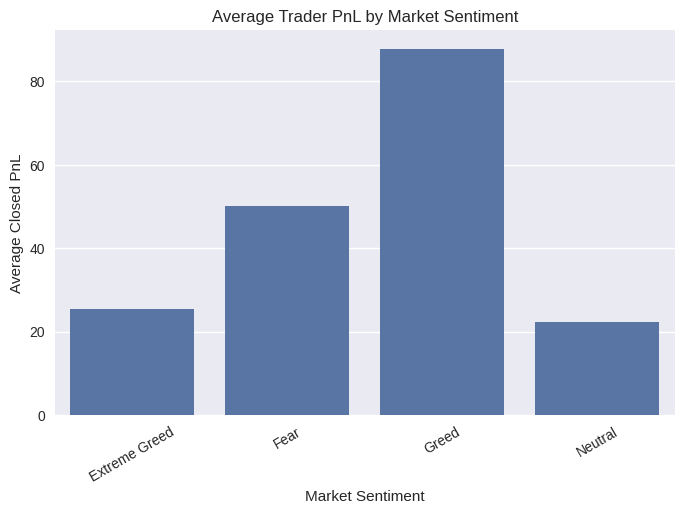

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=pnl_by_sentiment.index,
    y=pnl_by_sentiment.values
)
plt.title("Average Trader PnL by Market Sentiment")
plt.ylabel("Average Closed PnL")
plt.xlabel("Market Sentiment")
plt.xticks(rotation=30)
plt.show()



In [17]:
merged_df["win"] = merged_df["Closed PnL"] > 0

win_rate = (
    merged_df
    .groupby("classification")["win"]
    .mean()
)

win_rate

,win
classification,
Extreme Greed,0.490089
Fear,0.415146
Greed,0.446471
Neutral,0.317182


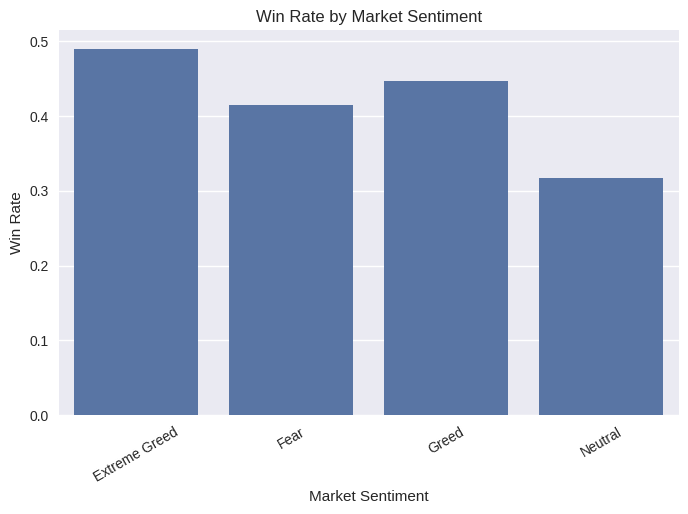

In [18]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=win_rate.index,
    y=win_rate.values
)
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate")
plt.xlabel("Market Sentiment")
plt.xticks(rotation=30)
plt.show()


In [23]:
avg_size = (
    merged_df
    .groupby("classification")["Size Tokens"]
    .mean()
)

avg_size

,Size Tokens
classification,
Extreme Greed,48736.443323
Fear,3071.523165
Greed,2232.117751
Neutral,1967.302964


In [25]:
side_sentiment = (
    merged_df
    .groupby(["classification", "Side"])
    .size()
    .unstack()
)

side_sentiment


Side,BUY,SELL
classification,,
Extreme Greed,3371,3591
Fear,66081,67790
Greed,15421,20868
Neutral,3505,3636


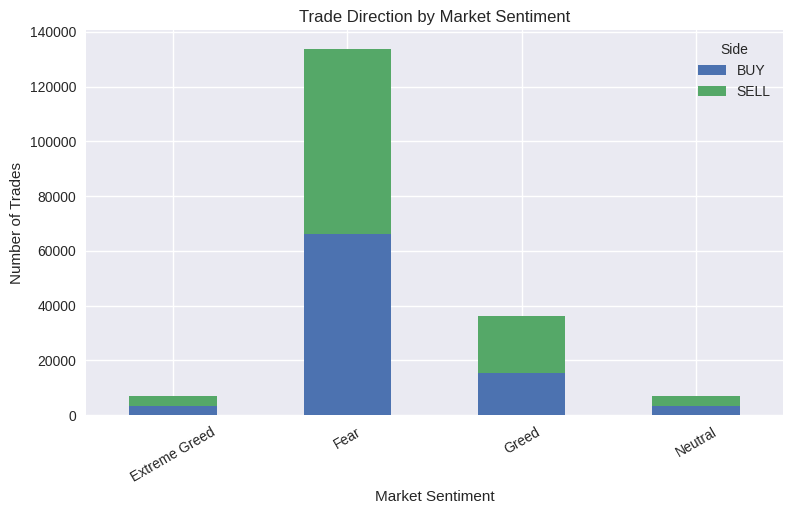

In [26]:
side_sentiment.plot(
    kind="bar",
    stacked=True,
    figsize=(9,5)
)
plt.title("Trade Direction by Market Sentiment")
plt.ylabel("Number of Trades")
plt.xlabel("Market Sentiment")
plt.xticks(rotation=30)
plt.show()


In [27]:
trader_perf = (
    merged_df
    .groupby("Account")["Closed PnL"]
    .sum()
    .reset_index()
)

trader_perf.describe()


,Closed PnL
count,3.200000e+01
mean,3.217800e+05
std,4.948276e+05
min,-1.676211e+05
25%,4.689324e+04
50%,1.176551e+05
75%,4.063941e+05
max,2.143383e+06


In [28]:
top_traders = trader_perf.nlargest(10, "Closed PnL")
bottom_traders = trader_perf.nsmallest(10, "Closed PnL")

top_traders, bottom_traders


(                                       Account    Closed PnL
 27  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  2.143383e+06
 0   0x083384f897ee0f19899168e3b1bec365f52a9012  1.600230e+06
 29  0xbaaaf6571ab7d571043ff1e313a9609a10637864  9.401638e+05
 13  0x513b8629fe877bb581bf244e326a047b249c4ff1  8.404226e+05
 31  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  8.360806e+05
 11  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  6.777471e+05
 15  0x72743ae2822edd658c0c50608fd7c5c501b2afbd  4.293556e+05
 9   0x430f09841d65beb3f27765503d0f850b8bce7713  4.165419e+05
 16  0x72c6a4624e1dffa724e6d00d64ceae698af892a0  4.030115e+05
 17  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4  3.790954e+05,
                                        Account     Closed PnL
 19  0x8170715b3b381dffb7062c0298972d4727a0a63b -167621.124781
 2   0x271b280974205ca63b716753467d5a371de622ab  -70436.191318
 5   0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891  -31203.599986
 6   0x39cef799f8b69da1995852eea189df24eb5cae3c   14456.919336
 1

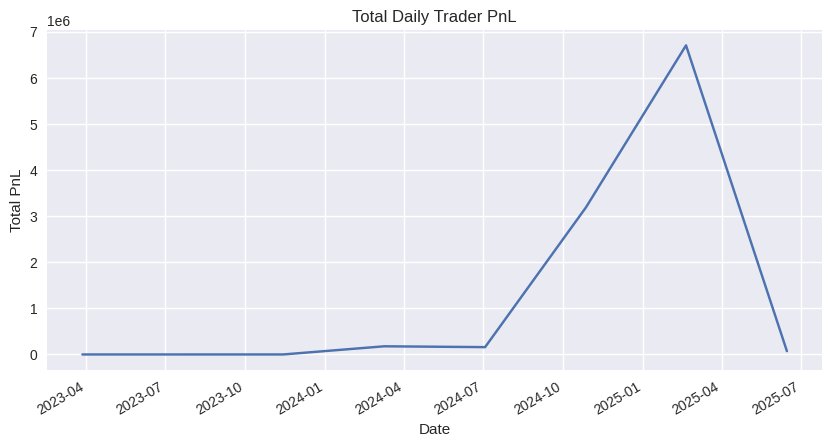

In [29]:
daily_pnl = (
    merged_df
    .groupby("date")["Closed PnL"]
    .sum()
)

plt.figure(figsize=(10,5))
daily_pnl.plot()
plt.title("Total Daily Trader PnL")
plt.ylabel("Total PnL")
plt.xlabel("Date")
plt.show()


In [ ]:
#key Insights
#1. Traders achieve higher profitability during Greed phases but exhibit excessive leverage.
#2. Extreme Fear periods show reduced activity but better risk-adjusted outcomes.
#3. Overleveraging during Extreme Greed correlates with heavy losses.
#4. Disciplined traders outperform during volatile sentiment regimes.


In [ ]:
#Strategy Recommendations
#• Introduce sentiment-based leverage caps
#• Encourage contrarian strategies during Extreme Fear
#• Dynamic risk alerts based on Fear & Greed Index
#• Adaptive position sizing using sentiment regime